[初學者碰上「機器學習」的第一道關卡：我應該使用哪種算法？](https://buzzorange.com/techorange/2017/05/25/which-method-in-ai/)

# Power Averaging

- 優化 AUC 指標的集成形式


- 在高度相關的模型上效果最好


- 公式 : 最終提交 = $\frac{(Submission1^{Power} \;\;+\;\; Submission2^{Power} \;\;+\;\; Submission3^{Power} \;\;+\;\; Submission4^{Power}\;\;)}{4} \;， Power \;is\; arbitrary. $


- 來源 : https://www.kaggle.com/code/edrickkesuma/power-averaging-is-your-friend/notebook

# Many nuances with power averaging

nuances (細節差別)<br>

**more detail:**<br>

- What power to use


- How to deal with clustered models (clusters of different correlations)


- How to keep improving your score


- 來源 : https://www.kaggle.com/code/edrickkesuma/in-depth-power-averaging-0-81848/notebook

## Visualize correlations
```python 

list_of_subs = [...]                          # 各模型答案的 list
group_labels = [...]                          # 他們的名字

import seaborn as sns
import matplotlib.pyplot as plt

data = np.corrcoef(list_of_subs)

fig, ax = plt.subplots(figsize=(20,20))
im = ax.imshow(data)

ax.set_xticks(np.arange(len(group_labels)))   # X 軸長度
ax.set_yticks(np.arange(len(group_labels)))

ax.set_xticklabels(group_labels)              # X 軸名字
ax.set_yticklabels(group_labels)

for i in range(len(group_labels)):            # X = 0,1,2,... & Y = 0 (橫的放)
    for j in range(len(group_labels)):        # (0,0),(0,1),...(0,N)  (橫的放)
        text = ax.text(j, i, data[i, j].round(5),
                       ha="center", va="center", color="w")

```

# 1. Finding a power

- **Correlation jumping**  (相關性跳躍)

```
1. 首先，找到最強的 submission，stack2_sub 

2. 接下來，我們找與 stack2_sub 相關性最高的 submission，為 stack4_sub，然後從相關矩陣中刪除 stack2_sub

3. 現在使用 stack4_sub 並找到與 stack4_sub 相關性最高的 submission，為 stack3_sub

4. 從相關矩陣中刪除 stack4_sub，重複此過程，直到刪除所有 submission

For this example, correlation jumping would go like this:
stack2 - stack4 - stack3 - stack1 - lgbm3 - lgbm1 - xgb4 - xgb2 - xgb3 - xgb5 - cb - lgbm2 - lgbm5 - lgbm4

```

- **Finding a threshold power**

```
基於相關性跳躍，開頭提交（stack2）和結尾提交（lgbm4）之間的相關性：

為 0.99869，基於此，我們通過反複試驗來找 0.99869^power = 0.9 時的 power

它會是這樣的：

0.99869^1 = 0.99869
0.99869^2 = 0.99738
...
0.99869^80 = 0.9004
0.99869^81 = 0.8992

這裡的閾值(power)功率為 80

```

# 2. Dealing with clustered submissions / Ensembling

```

集群提交是指提交之間的相關性很高的組（您可以通過顏色組在某種程度上看到）

例如：xgb1、xgb2、xgb3、xgb4有一個淺黃色的小框（相互關聯度高）

你把它們當作 cluster1

再比如：stack2、stack3、stack4也有一個淺黃色框

你把它們當作 cluster2

將'所有'提交分組後，執行以下操作:

1. 每個集群中的 Power Averaging (帶公式)

2. 除以該集群中的提交數量

3. 全部加起來

4. 除以集群總數
```

- **集群公式**： $\frac{\frac{cluster1}{n\;in\;cluster1} \;\;\;\;+\;\; \frac{cluster2}{n\;in\;cluster2} \;\;\;\;+\;\; \frac{cluster3}{n\;in\;cluster3}}{ n\;of\;clusters}$


- **Power Averaging 進化版**

# 3. How to keep improving your score


還可以更好，兩件事改善混合：

1. **嘗試不同的 powers** : 將 powers 從閾值上下移動 5 或 10，有時它會提高 0.00001


2. **添加更多提交** : 越多越好！我添加了 2 個提交，總體增加了 0.00004


更多理論細節 : https://medium.com/data-design/reaching-the-depths-of-power-geometric-ensembling-when-targeting-the-auc-metric-2f356ea3250e

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:

logistic_sub = pd.read_csv(r"C:\Users\user\Desktop\2022data\final_claim\logistic_sub.csv")
decision_tree5_sub = pd.read_csv(r"C:\Users\user\Desktop\2022data\final_claim\decision_tree5_sub.csv")
random_forest60_sub = pd.read_csv(r"C:\Users\user\Desktop\2022data\final_claim\random_forest60_sub.csv")
xgboost_sub = pd.read_csv(r"C:\Users\user\Desktop\2022data\final_claim\xgboost_sub.csv")
Light_GBM_sub = pd.read_csv(r"C:\Users\user\Desktop\2022data\final_claim\Light_GBM_sub.csv")



#路徑字串開頭要寫 r & 檔案名稱.csv                         
# r :為了不讓 \ 被讀成特殊字元 EX: \n
#指定欄位 id 為索引 (取代原本 0.1...957918的位置)


In [3]:
# 各模型答案的 dataframe

fomod = pd.concat((logistic_sub,decision_tree5_sub.iloc[:,1],random_forest60_sub.iloc[:,1],
                   xgboost_sub.iloc[:,1],Light_GBM_sub.iloc[:,1]), axis = 'columns')
fomod.columns = ['id','logistic','decesion_tree','random_forest','xgboost','lightgbm']
fomod


,id,logistic,decesion_tree,random_forest,xgboost,lightgbm
0,957919,0.395188,0.583207,0.653503,0.564265,0.564811
1,957920,0.207112,0.129017,0.107132,0.120142,0.118635
2,957921,0.375288,0.595605,0.621970,0.633736,0.617334
3,957922,0.263373,0.144138,0.129830,0.125701,0.131201
4,957923,0.285499,0.151109,0.170366,0.150856,0.142004
...,...,...,...,...,...,...
493469,1451388,0.581088,0.762203,0.742159,0.819749,0.817965
493470,1451389,0.216424,0.129017,0.151462,0.109735,0.112421
493471,1451390,0.844771,0.757146,0.766042,0.772190,0.752897
493472,1451391,0.223254,0.123806,0.204669,0.137073,0.135420


In [4]:
fomod.shape

(493474, 6)

array([[1.        , 0.84639208, 0.83042865, 0.84226411, 0.84110803],
       [0.84639208, 1.        , 0.98977617, 0.98815567, 0.98855431],
       [0.83042865, 0.98977617, 1.        , 0.98406852, 0.98416527],
       [0.84226411, 0.98815567, 0.98406852, 1.        , 0.99927275],
       [0.84110803, 0.98855431, 0.98416527, 0.99927275, 1.        ]])

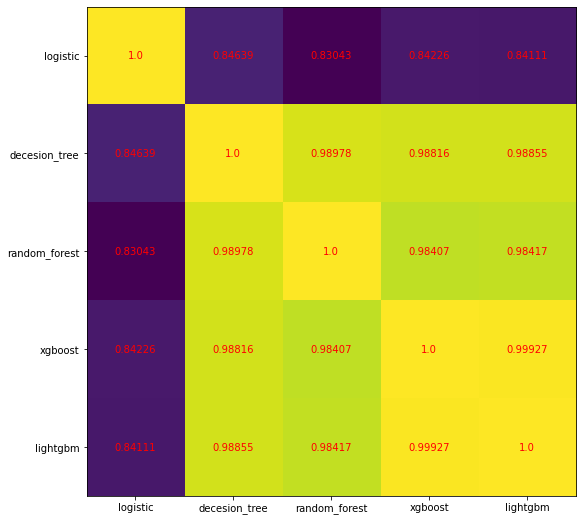

In [5]:
# Visualize correlations

list_of_subs = [fomod.iloc[:,1],fomod.iloc[:,2],fomod.iloc[:,3],fomod.iloc[:,4],fomod.iloc[:,5]]      # 各模型答案的 list
group_labels = ['logistic','decesion_tree','random_forest','xgboost','lightgbm']                      # 他們的名字

data = np.corrcoef(list_of_subs)

fig, ax = plt.subplots(figsize=(12,9))
im = ax.imshow(data)

ax.set_xticks(np.arange(len(group_labels)))   # X 軸長度
ax.set_yticks(np.arange(len(group_labels)))

ax.set_xticklabels(group_labels)              # X 軸名字
ax.set_yticklabels(group_labels)

for i in range(len(group_labels)):            # X = 0,1,2,... & Y = 0 (橫的放)
    for j in range(len(group_labels)):        # (0,0),(0,1),...(0,N)  (橫的放)
        text = ax.text(j, i, data[i, j].round(5),
                       ha="center", va="center", color="r")
data       

In [8]:
# fomod.to_csv("C:/Users/user/Desktop/all_model_claim.csv")

sns.heatmap 的 cmap 可用顏色
```
'Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 
'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 
'Oranges_r','PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r',
'PuBu', 'PuBuGn','PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r',
'RdGy', 'RdGy_r', 'RdPu','RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r',
'Set2', 'Set2_r', 'Set3', 'Set3_r','Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r',
'YlGn_r','YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 
'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r','cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 
'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 
'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat','gist_heat_r', 'gist_ncar', 'gist_ncar_r', 
'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 'gnuplot2',
'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 
'inferno_r','jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r','ocean', 'ocean_r',
'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r','seismic',
'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r',
'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted',
'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r'
```
- 參考 : https://seaborn.pydata.org/generated/seaborn.heatmap.html

,logistic,decesion_tree,random_forest,xgboost,lightgbm
logistic,1.000000,0.846392,0.830429,0.842264,0.841108
decesion_tree,0.846392,1.000000,0.989776,0.988156,0.988554
random_forest,0.830429,0.989776,1.000000,0.984069,0.984165
xgboost,0.842264,0.988156,0.984069,1.000000,0.999273
lightgbm,0.841108,0.988554,0.984165,0.999273,1.000000


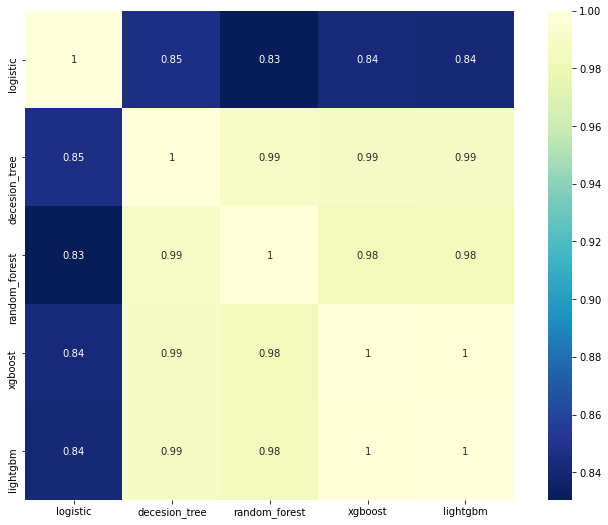

In [9]:
# correlation matrix

corrmat_ = fomod.iloc[:,1:6].corr()      # 'list' object has no attribute 'corr'


f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_, square=True,annot=True,cmap = 'YlGnBu_r')

corrmat_

,decesion_tree,random_forest,xgboost,lightgbm
decesion_tree,1.000000,0.989776,0.988156,0.988554
random_forest,0.989776,1.000000,0.984069,0.984165
xgboost,0.988156,0.984069,1.000000,0.999273
lightgbm,0.988554,0.984165,0.999273,1.000000


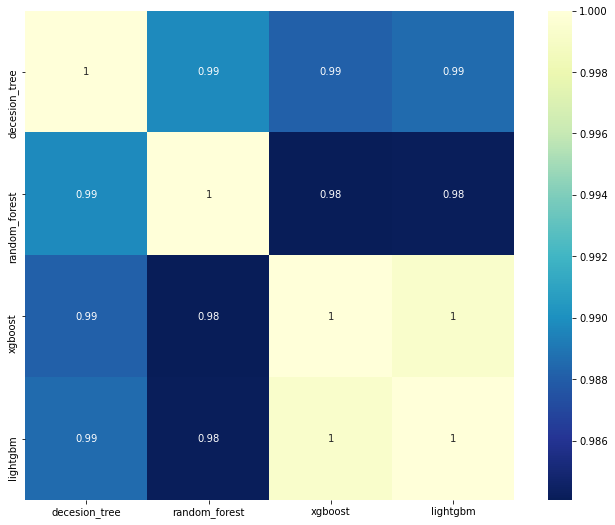

In [10]:
# correlation matrix

corrmat_2 = fomod.iloc[:,2:6].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_2, square=True,annot=True,cmap = 'YlGnBu_r')

corrmat_2

,logistic,decesion_tree,random_forest,xgboost
logistic,1.000000,0.846392,0.830429,0.842264
decesion_tree,0.846392,1.000000,0.989776,0.988156
random_forest,0.830429,0.989776,1.000000,0.984069
xgboost,0.842264,0.988156,0.984069,1.000000


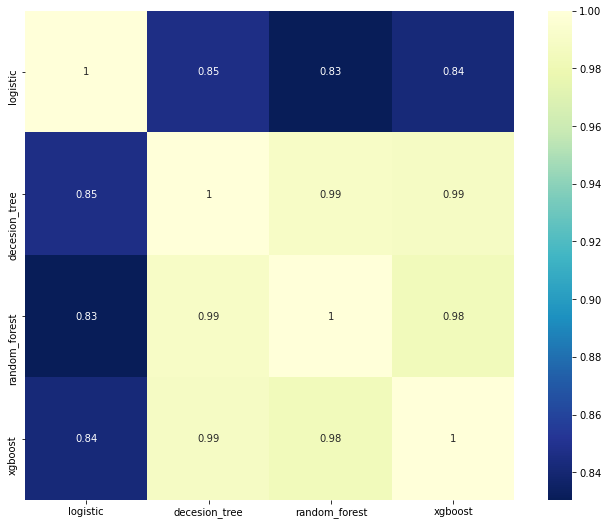

In [11]:
# correlation matrix

corrmat_2 = fomod.iloc[:,1:5].corr()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat_2, square=True,annot=True,cmap = 'YlGnBu_r')

corrmat_2

# 標準化/歸一化
**歸一化**<br>
- $\frac{x_i \;-\; min(x_i)}{max(x_i) \;-\; min(x_i)}$

**標準化**<br>
- $\frac{x_i \;-\; \bar{x}}{sd(x)}$

**標準化/歸一化的好處**
- 提升模型精度
    ```
    讓各個特徵對結果做出的貢獻相同
    歸一化處理主要包括
      數據同趨化處理:解決不同性質數據問題,使所有指標對測評方案的作用力同趨化，再加總
      無量綱化處理:解決數據的可比性。即各指標值都處於同一個數量級別上，可以進行綜合測評分析。
    ```
- 提升收斂速度

**標準化/歸一化的對比分析**
- 標準化更好保持了樣本間距。當樣本中有異常點時，歸一化有可能將正常的樣本“擠”到一起去
- 標準化更符合統計學假設。對一個數值特徵來說，很大可能它是服從常態分佈的。標準化其實是基於這個隱含假設
- 數據標準化為了不同特徵之間具備可比性，經過標準化變換之後的特徵分佈沒有發生改變
- 數據歸一化的目的是使得各特徵對目標變量的影響一致，會將特徵數據進行伸縮變化，歸一化是會改變特徵數據分佈的


**標準化在機器學習中運用的情況**
- 邏輯回歸必須要進行標準化嗎？
    ```
    取決於我們的邏輯回歸是不是用L1、L2正則(即算歐式距離)
    L1正則時，是簡單將參數的絕對值相加,，因為它們的大小級別不一樣，導致L1只會對級別比較大的參數有作用，那些小的參數將被忽略
    不用正則，標準化並不是必須的，損失函數只是僅僅在度量預測與真實的差距
    用正則，那麼標準化是必須的，還要度量參數值是否足夠小。而參數值的大小程度或者說大小的級別是與特徵的數值範圍相關的
    ```
- **正則化是有偏估計，會對權重進行懲罰。在量綱不同的情況，正則化會帶來更大的偏差**
    
    
    
- 如果不用正則，那麼標準化對邏輯回歸有什麼好處嗎？
    ```
    標準化後，得出的參數值的大小可以反應出不同特徵對樣本label的貢獻度，方便我們進行特徵篩選
    如果不做標準化，是不能這樣來篩選特徵的
    ```
- 做標準化有什麼注意事項嗎？
    ```
    最大的注意事項就是先拆分出test集，不要在整個數據集上做標準化，
    因為那樣會將test集的信息引入到訓練集中
    ```

**需要標準化數據的算法(基於距離度量進行模型預測和分類)**<br>
`聚類 : 依賴於對類間距離和類內聚類之間的衡量，標準化`<br>
`距離 : 對特徵之間不同取值範圍非常敏感 `
```
PCA、SVM、 SGD、linear/logistic regression、Kmeans、KNN、嶺迴歸、Lasso

對特徵取值大小不敏感，DecisionTree、0/1取值的特徵、基於平方損失的最小二乘法OLS、較多類別變量的數據，不需要歸一化 
```

來源 : https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/preprocessing-data-%E6%95%B8%E6%93%9A%E7%89%B9%E5%BE%B5%E6%A8%99%E6%BA%96%E5%8C%96%E5%92%8C%E6%AD%B8%E4%B8%80%E5%8C%96-9bd3e5a8f2fc

SVM : https://tangshusen.me/2018/10/27/SVM/

## 歸一化對梯度下降的影響

- 加快梯度下降求最優解的速度和有可能提高精度

```
  1. 兩個特徵的區間相差非常大，其所形成的等高線非常尖，
     當使用梯度下降法尋求最優解時，很有可能走「之字型」路線（垂直等高線走）
     導致需要疊代很多次才能收斂

  2. 對兩個原始特徵進行了歸一化，其對應的等高線顯得很圓，在梯度下降進行求解時能較快的收斂

```
**機器學習模型使用梯度下降法求最優解時，歸一化往往非常有必要，否則很難收斂甚至不能收斂**


## 需要歸一化的算法
`一般算法如果本身受量綱影響較大，或者相關優化函數受量綱影響大，則需要進行特徵歸一化。`

- 最優化問題 : Adaboost、SVM、LR、Knn、KMeans




- 對於決策樹這類的算法，不受量綱影響，不需要進行歸一化處理。


- 樹模型特徵歸一化可能會降低模型的準確率，但是能夠使模型更加平穩


參考 : https://kknews.cc/code/ze2mxra.html

- **L0是指向量中非0的元素的個數**
    1. 可以實現稀疏，L0很難優化求解 
    2. L1是L0的最優凸近似，它比L0要容易優化求解

- **L1指向量中各個元素絕對值之和，也稱“稀疏規則算子”（Lasso regularization）**

    爲什麼L1會使權值稀疏？

    1. 它是L0的最優凸近似
    2. 任何的規則化算子，如果他在Wi=0的地方不可微，並且可以分解爲一個“求和”的形式，那麼這個規則化算子就可以實現稀疏<br>
       W的L1是絕對值，|w|在w=0處是不可微，但這還是不夠直觀。


- **L2，"嶺迴歸"（Ridge Regression），"權值衰減"(weight decay)**
- **L2指向量各元素的平方和然後求平方根**    
    ```
    改善過擬合，讓L2的規則項||W||2最小，可以使得W的每個元素都很小，都接近於0，但與L1範數不同，它不會讓它等於0
    越小的參數說明模型越簡單，越簡單的模型則越不容易產生過擬合現象。
    
    ```

### L1

參數稀疏有什麼好處?

1. 特徵選擇 : 稀疏規則化算子的引入就是爲了完成特徵自動選擇，它會學習地去掉這些沒有信息的特徵，也就是把這些特徵對應的權重置爲0


2. 可解釋性 : 如果最後學習到的w*就只有很少的非零元素，例如只有5個非零的wi，那麼我們就有理由相信，這些對應的特徵提供的信息是巨大的、決策性的


### L2

```
condition number總結：一個矩陣（或者它所描述的線性系統）的穩定性或者敏感度的度量，
如果一個矩陣的condition number在1附近，那麼它就是well-conditioned的
如果遠大於1，那麼它就是ill-conditioned的
如果一個系統是ill-conditioned的，它的輸出結果就不要太相信了
```

1. 學習理論的角度 : 從學習理論的角度來說，L2範數可以防止過擬合，提升模型的泛化能力


2. 優化計算的角度 : 有助於處理 condition number不好的情況下矩陣求逆很困難的問題
    ```
    優化有兩大難題，
    
    1. 局部最小值，找的是全局最小值，如果局部最小值太多，那我們的優化算法就很容易陷入局部最小
        
    2. ill-condition病態問題，系統對誤差(係數矩陣A或者b)太敏感了，以至於我們的解的誤差更大
   
    當我們的樣本X的數目比每個樣本的維度還要小的時候，矩陣XTX將會不是滿秩的，也就是XTX不可逆
    無窮多個解（因爲我們方程組的個數小於未知數的個數），加L2規則項後，就可以直接求逆了
    ```
    
來源 : https://www.twblogs.net/a/5b82627a2b717766a1e804db

L1,L2 Regularization 到底正則化了什麼 ?https://allen108108.github.io/blog/2019/10/22/L1%20,%20L2%20Regularization%20%E5%88%B0%E5%BA%95%E6%AD%A3%E5%89%87%E5%8C%96%E4%BA%86%E4%BB%80%E9%BA%BC%20_/

advisor(給建議的)